In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiHeadAttention(nn.Module):
    def __init__(self, features, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.features = features
        self.depth = features // num_heads

        self.Wq = nn.Linear(features, features)
        self.Wk = nn.Linear(features, features)
        self.Wv = nn.Linear(features, features)

        self.fc = nn.Linear(features, features)

    def forward(self, x):
        batch_size, num_points, _ = x.shape

        query = self.Wq(x).view(batch_size, num_points, self.num_heads, self.depth).transpose(1, 2)
        key = self.Wk(x).view(batch_size, num_points, self.num_heads, self.depth).transpose(1, 2)
        value = self.Wv(x).view(batch_size, num_points, self.num_heads, self.depth).transpose(1, 2)

        scores = torch.matmul(query, key.transpose(-2, -1)) / (self.depth ** 0.5)
        attention = F.softmax(scores, dim=-1)

        out = torch.matmul(attention, value).transpose(1, 2).contiguous()
        out = out.view(batch_size, num_points, self.features)
        
        return self.fc(out)

class MHA_AutoEncoder(nn.Module):
    def __init__(self, point_features, num_heads, latent_dim):
        super().__init__()
        self.encoder = MultiHeadAttention(point_features, num_heads)
        self.decoder = MultiHeadAttention(point_features, num_heads)
    
    def forward(self, x):
        batch_size, num_points, _ = x.shape
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return decoded
    
    def encode_only(self, x):
        # This method returns only the encoded output
        return self.encoder(x)



In [2]:
import sys
sys.path.append('/workspace/utils')
from utils3d_model import load_point_clouds, display_point_clouds
from optimization_utils import objective_function, build_transformation_matrix,transform_point_cloud_numpy
import os
import numpy as np

folder_path = '/workspace/datasets/apollo/car_models_json'
files = os.listdir(folder_path)

# Load point clouds from specified files
point_clouds, titles = load_point_clouds(folder_path, files, len(files))
initial_pc = point_clouds["SUV"][0]  # Assuming first point cloud as the initial
initial_pc.shape

(4294, 3)

In [3]:
num_transformations = 100
point_cloud_dataset = []
np.random.seed(1)
tranlation_vector = np.zeros(3)
# Generate random transformation matrices
for i in range(num_transformations):
    rotation_vector = np.random.rand(3) * 2 * np.pi
    transformation_matrix = build_transformation_matrix(rotation_vector, tranlation_vector)
    point_cloud_dataset.append(transform_point_cloud_numpy(initial_pc, transformation_matrix))


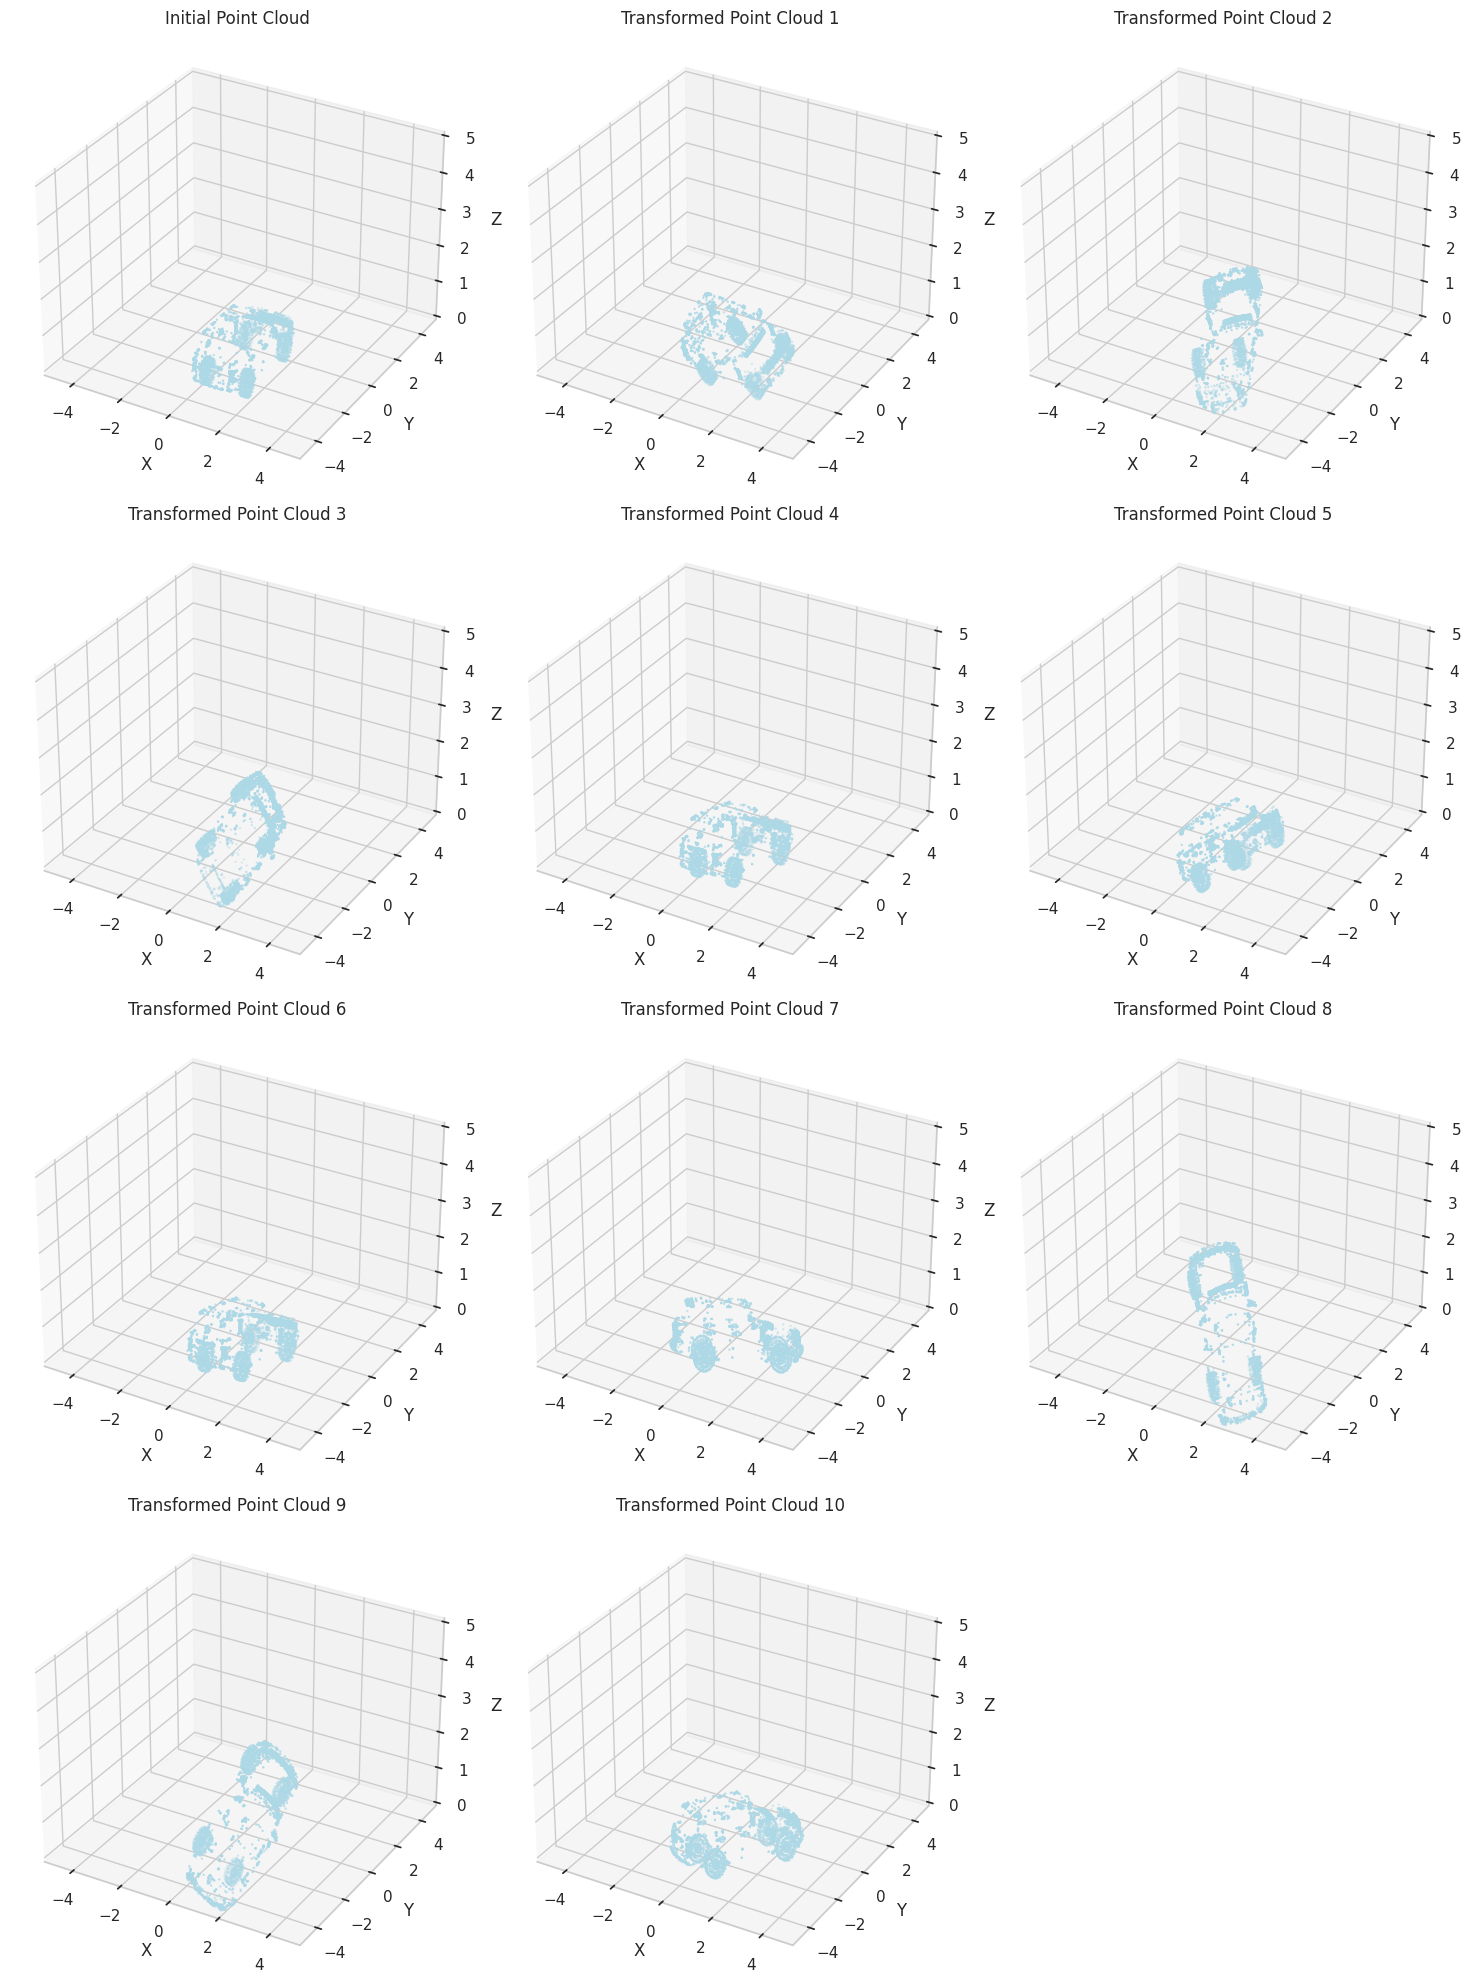

In [4]:
titles = ["Initial Point Cloud"] + [f"Transformed Point Cloud {i}" for i in range(1, 10 + 1)]
display_point_clouds([initial_pc] + point_cloud_dataset[:10], titles)

In [5]:
# Convert point clouds to torch tensors
point_cloud_dataset = torch.tensor(point_cloud_dataset, dtype=torch.float32)
point_cloud_dataset.shape

/tmp/ipykernel_4731/3499426091.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  point_cloud_dataset = torch.tensor(point_cloud_dataset, dtype=torch.float32)


torch.Size([100, 4294, 3])

In [6]:
# Define the model
point_features = 3
num_heads = 3
latent_dim = 64
model = MHA_AutoEncoder(point_features, num_heads, latent_dim)

# Define using the mean squared error loss
criterion = nn.MSELoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Move the model to the chosen device
model = model.to(device)

Using device: cuda


Epoch 1, Batch 1/10, Loss: 1.2393
Epoch 1, Batch 2/10, Loss: 1.1949
Epoch 1, Batch 3/10, Loss: 1.2479


KeyboardInterrupt: 

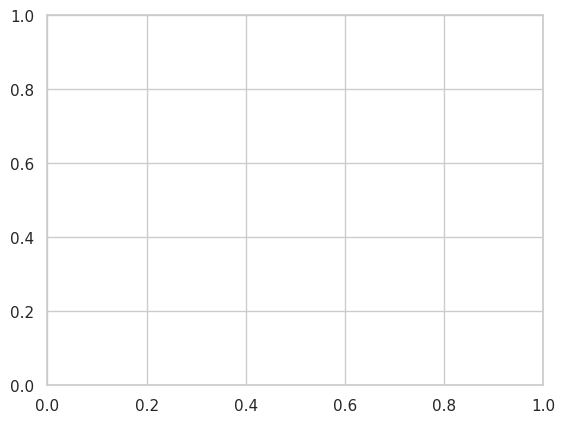

In [7]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

plt.ion()  # Turn on the interactive mode in matplotlib
fig, ax = plt.subplots()
losses = []

num_epochs = 100
batch_size = 10  # Smaller batch size
num_batches = len(point_cloud_dataset) // batch_size

for epoch in range(num_epochs):
    epoch_losses = []
    for i in range(num_batches):
        batch_data = point_cloud_dataset[i * batch_size:(i + 1) * batch_size].to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_data)
        loss = criterion(outputs, batch_data)
        loss.backward()
        optimizer.step()
        
        # Append loss to the list and print it
        batch_loss = loss.item()
        epoch_losses.append(batch_loss)
        print(f"Epoch {epoch+1}, Batch {i+1}/{num_batches}, Loss: {batch_loss:.4f}")
        
    # Calculate the average loss for the epoch
    average_loss = sum(epoch_losses) / len(epoch_losses)
    losses.append(average_loss)
    
    # Update the plot
    ax.clear()
    ax.plot(losses, label='Training Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training Loss per Epoch')
    ax.legend()
    display(fig)    # Display the figure
    clear_output(wait=True)  # Clear the output to make ready for the next plot update

plt.ioff()  # Turn off the interactive mode


In [8]:
#load model from file 
model = MHA_AutoEncoder(point_features, num_heads, latent_dim)
model.load_state_dict(torch.load('/workspace/examples/mha_autoencoder.pth'))
model.to(device)

MHA_AutoEncoder(
  (encoder): MultiHeadAttention(
    (Wq): Linear(in_features=3, out_features=3, bias=True)
    (Wk): Linear(in_features=3, out_features=3, bias=True)
    (Wv): Linear(in_features=3, out_features=3, bias=True)
    (fc): Linear(in_features=3, out_features=3, bias=True)
  )
  (decoder): MultiHeadAttention(
    (Wq): Linear(in_features=3, out_features=3, bias=True)
    (Wk): Linear(in_features=3, out_features=3, bias=True)
    (Wv): Linear(in_features=3, out_features=3, bias=True)
    (fc): Linear(in_features=3, out_features=3, bias=True)
  )
)

In [9]:
#display the input and output point clouds
model.eval()
with torch.no_grad():
    outputs = model(point_cloud_dataset[:10].to(device))
    outputs = outputs.cpu().numpy()

In [10]:
#defi degree values from 0 to 360
degree_values = np.arange(0, 360, 10)
point_cloud_dataset_rotated_yaw = []
point_cloud_dataset_rotated_pitch = []
point_cloud_dataset_rotated_roll = []

for degree in degree_values:
    rotation_vector = np.array([0, np.radians(degree), 0])
    transformation_matrix = build_transformation_matrix(rotation_vector, tranlation_vector)
    point_cloud_dataset_rotated_yaw.append(transform_point_cloud_numpy(initial_pc, transformation_matrix))
    
    rotation_vector = np.array([np.radians(degree), 0, 0])
    transformation_matrix = build_transformation_matrix(rotation_vector, tranlation_vector)
    point_cloud_dataset_rotated_pitch.append(transform_point_cloud_numpy(initial_pc, transformation_matrix))

    rotation_vector = np.array([0, 0, np.radians(degree)])
    transformation_matrix = build_transformation_matrix(rotation_vector, tranlation_vector)
    point_cloud_dataset_rotated_roll.append(transform_point_cloud_numpy(initial_pc, transformation_matrix))

In [11]:
# Convert point clouds to torch tensors
point_cloud_dataset_rotated_yaw = torch.tensor(point_cloud_dataset_rotated_yaw, dtype=torch.float32)
point_cloud_dataset_rotated_pitch = torch.tensor(point_cloud_dataset_rotated_pitch, dtype=torch.float32)
point_cloud_dataset_rotated_roll = torch.tensor(point_cloud_dataset_rotated_roll, dtype=torch.float32)

# Move the point clouds to the chosen device
point_cloud_dataset_rotated_yaw = point_cloud_dataset_rotated_yaw.to(device)
point_cloud_dataset_rotated_pitch = point_cloud_dataset_rotated_pitch.to(device)
point_cloud_dataset_rotated_roll = point_cloud_dataset_rotated_roll.to(device)

# Get the outputs from the model
with torch.no_grad():
    outputs_yaw = model.encode_only(point_cloud_dataset_rotated_yaw)
    outputs_pitch = model.encode_only(point_cloud_dataset_rotated_pitch)
    outputs_roll = model.encode_only(point_cloud_dataset_rotated_roll)

# Convert the outputs to numpy arrays
outputs_yaw = outputs_yaw.cpu().numpy()
outputs_pitch = outputs_pitch.cpu().numpy()
outputs_roll = outputs_roll.cpu().numpy()




Outputs Yaw Shape: (36, 12882)
Outputs Pitch Shape: (36, 12882)
Outputs Roll Shape: (36, 12882)


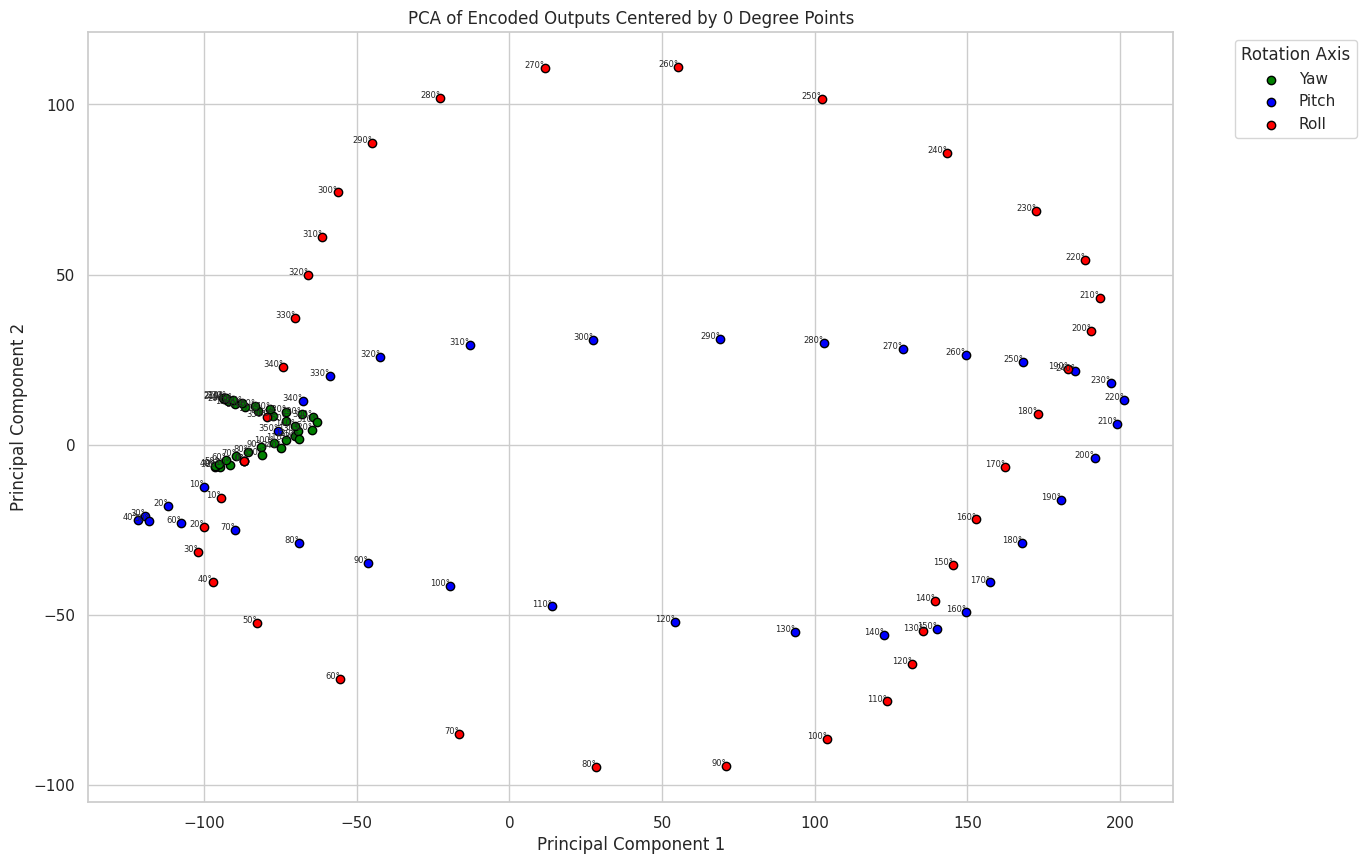

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

if len(outputs_yaw.shape) == 3:
    outputs_yaw = outputs_yaw.reshape(outputs_yaw.shape[0], -1)
    outputs_pitch = outputs_pitch.reshape(outputs_pitch.shape[0], -1)
    outputs_roll = outputs_roll.reshape(outputs_roll.shape[0], -1)

# Check shapes
print('Outputs Yaw Shape:', outputs_yaw.shape)
print('Outputs Pitch Shape:', outputs_pitch.shape)
print('Outputs Roll Shape:', outputs_roll.shape)

# Assuming 'outputs_yaw', 'outputs_pitch', 'outputs_roll' are already defined
all_outputs = np.concatenate([outputs_yaw, outputs_pitch, outputs_roll], axis=0)

# Identifying the 0-degree sample indices (first sample in each set)
zero_degree_indices = [0, len(outputs_yaw), len(outputs_yaw) + len(outputs_pitch)]

# Subtract the mean of the 0-degree samples from all samples
zero_degree_mean = np.mean(all_outputs[zero_degree_indices, :], axis=0)
all_outputs -= zero_degree_mean

# Apply PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(all_outputs)

# Prepare labels for plotting
labels = ['Yaw'] * len(outputs_yaw) + ['Pitch'] * len(outputs_pitch) + ['Roll'] * len(outputs_roll)
degrees = np.tile(degree_values, 3)  # Repeat degree_values for yaw, pitch, roll

# Plotting
plt.figure(figsize=(14, 10))
colors = {'Roll': 'red', 'Yaw': 'green', 'Pitch': 'blue'}
for i, label in enumerate(labels):
    plt.scatter(reduced_data[i, 0], reduced_data[i, 1], label=label if i in zero_degree_indices else "",
                color=colors[label], edgecolors='black')
    plt.text(reduced_data[i, 0], reduced_data[i, 1], f"{int(degrees[i])}°", fontsize=6, ha='right')

plt.title('PCA of Encoded Outputs Centered by 0 Degree Points')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title="Rotation Axis", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()




In [ ]:
#save model
torch.save(model.state_dict(), 'mha_autoencoder.pth')

In [33]:
#get shape of encoded output
encoded_output = model.encode_only(point_cloud_dataset[:1].to(device))
encoded_output.shape

torch.Size([1, 4294, 3])

In [34]:
point_cloud_dataset[:1].to(device).shape

torch.Size([1, 4294, 3])

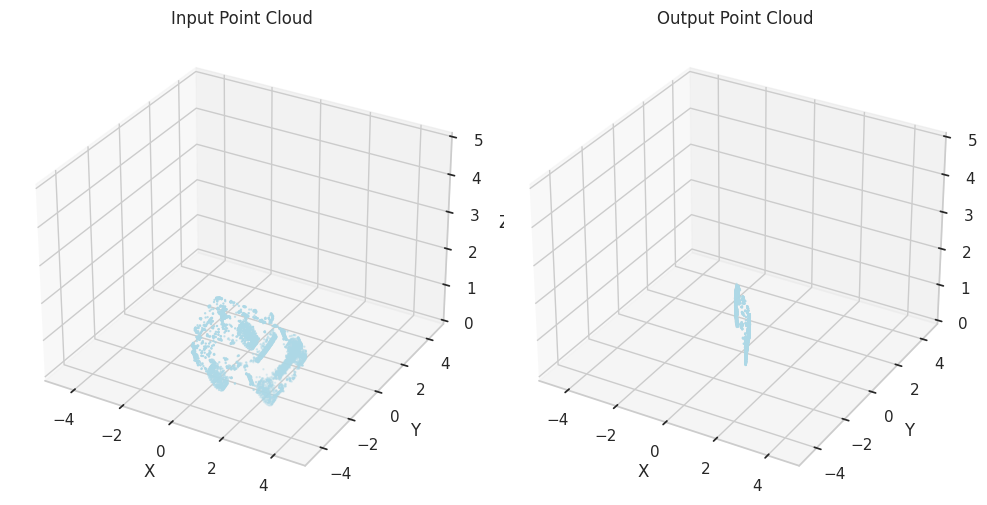

In [43]:
#SHOW BOTH INPUT AND OUTPUT POINT CLOUDS
display_point_clouds([point_cloud_dataset[0].cpu().numpy(), encoded_output[0].cpu().detach().numpy()], ['Input Point Cloud', 'Output Point Cloud'])